# KerasCV에서 Stable Diffusion을 사용한 고성능 이미지 생성

**저자:** [fchollet](https://twitter.com/fchollet), [lukewood](https://twitter.com/luke_wood_ml), [divamgupta](https://github.com/divamgupta)  
**생성일:** 2022/09/25  
**최종편집일:** 2022/09/25  
**설명:** KerasCV의 Stable Diffusion 모델을 사용하여 새로운 이미지를 생성합니다.

## 개요

이 가이드에서는, [stability.ai](https://stability.ai/)의 텍스트-이미지 모델인
[Stable Diffusion](https://github.com/CompVis/stable-diffusion)의 KerasCV 구현을 사용하여,
텍스트 프롬프트를 기반으로 새로운 이미지를 생성하는 방법을 보여줍니다.

Stable Diffusion은 강력한 오픈소스 텍스트-이미지 생성 모델입니다.
텍스트 프롬프트에서 이미지를 쉽게 생성할 수 있는 오픈소스 구현이 여러 개 있지만,
KerasCV는 몇 가지 뚜렷한 이점을 제공합니다.
여기에는 [XLA 컴파일](https://www.tensorflow.org/xla)과 [혼합 정밀도](https://www.tensorflow.org/guide/mixed_precision) 지원이 포함되며,
이를 통해 최첨단 생성 속도를 달성합니다.

이 가이드에서는, KerasCV의 Stable Diffusion 구현을 살펴보고,
이러한 강력한 성능 향상을 사용하는 방법을 보여주고,
이러한 향상이 제공하는 성능 이점을 살펴보겠습니다.

**참고:** `torch` 백엔드에서 이 가이드를 실행하려면,
모든 곳에서 `jit_compile=False`를 설정하세요.
Stable Diffusion을 위한 XLA 컴파일은 현재 torch에서 작동하지 않습니다.

시작하려면, 몇 가지 종속성을 설치하고 몇 가지 import를 정리하겠습니다.

In [1]:
# 이 노트북은 Keras cv가 설치되어 있다는 가정 하에 진행됩니다.
# 이 노트북은 Keras 3이 설치되어 있다는 가정 하에 진행됩니다.
#
# !pip install -q --upgrade keras-cv
# !pip install -q --upgrade keras  # Upgrade to Keras 3.

In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
# os.environ["KERAS_BACKEND"] = "jax"
# os.environ["KERAS_BACKEND"] = "torch"

In [3]:
from keras import backend
print(backend.backend())

tensorflow


In [4]:
import time
import keras_cv
import keras
import matplotlib.pyplot as plt

In [5]:
import tensorflow as tf

print(tf.__version__)
print(keras.__version__)

2.17.0
3.4.1


## 소개

(먼저 주제를 설명한 다음 구현 방법을 보여주는) 대부분 튜토리얼과 달리,
텍스트-이미지 생성은 말하기보다는 보여주기가 더 쉽습니다.

`keras_cv.models.StableDiffusion()`의 힘을 확인해 보세요.

먼저 모델을 구성합니다.

In [6]:
model = keras_cv.models.StableDiffusion(
    img_width=512, img_height=512, jit_compile=False
)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


다음으로, 프롬프트를 제공합니다.

In [7]:
import math

import numpy as np

from keras_cv.src.api_export import keras_cv_export
from keras_cv.src.backend import keras
from keras_cv.src.backend import ops
from keras_cv.src.backend import random
from keras_cv.src.models.stable_diffusion.clip_tokenizer import SimpleTokenizer
from keras_cv.src.models.stable_diffusion.constants import _ALPHAS_CUMPROD
from keras_cv.src.models.stable_diffusion.constants import _UNCONDITIONAL_TOKENS
from keras_cv.src.models.stable_diffusion.decoder import Decoder
from keras_cv.src.models.stable_diffusion.diffusion_model import DiffusionModel
from keras_cv.src.models.stable_diffusion.diffusion_model import (
    DiffusionModelV2,
)
from keras_cv.src.models.stable_diffusion.image_encoder import ImageEncoder
from keras_cv.src.models.stable_diffusion.text_encoder import TextEncoder
from keras_cv.src.models.stable_diffusion.text_encoder import TextEncoderV2

MAX_PROMPT_LENGTH = 77


class StableDiffusionBase:
    """Base class for stable diffusion and stable diffusion v2 model."""

    def __init__(
        self,
        img_height=512,
        img_width=512,
        jit_compile=True,
    ):
        # UNet requires multiples of 2**7 = 128
        img_height = round(img_height / 128) * 128
        img_width = round(img_width / 128) * 128
        self.img_height = img_height
        self.img_width = img_width

        # lazy initialize the component models and the tokenizer
        self._image_encoder = None
        self._text_encoder = None
        self._diffusion_model = None
        self._decoder = None
        self._tokenizer = None

        self.jit_compile = jit_compile

    def text_to_image(
        self,
        prompt,
        negative_prompt=None,
        batch_size=1,
        num_steps=50,
        unconditional_guidance_scale=7.5,
        seed=None,
    ):
        encoded_text = self.encode_text(prompt)

        return self.generate_image(
            encoded_text,
            negative_prompt=negative_prompt,
            batch_size=batch_size,
            num_steps=num_steps,
            unconditional_guidance_scale=unconditional_guidance_scale,
            seed=seed,
        )

    def encode_text(self, prompt):
        """Encodes a prompt into a latent text encoding.

        The encoding produced by this method should be used as the
        `encoded_text` parameter of `StableDiffusion.generate_image`. Encoding
        text separately from generating an image can be used to arbitrarily
        modify the text encoding prior to image generation, e.g. for walking
        between two prompts.

        Args:
            prompt: a string to encode, must be 77 tokens or shorter.

        Example:

        ```python
        from keras_cv.src.models import StableDiffusion

        model = StableDiffusion(img_height=512, img_width=512, jit_compile=True)
        encoded_text  = model.encode_text("Tacos at dawn")
        img = model.generate_image(encoded_text)
        ```
        """
        # Tokenize prompt (i.e. starting context)
        inputs = self.tokenizer.encode(prompt)
        if len(inputs) > MAX_PROMPT_LENGTH:
            raise ValueError(
                f"Prompt is too long (should be <= {MAX_PROMPT_LENGTH} tokens)"
            )
        phrase = inputs + [49407] * (MAX_PROMPT_LENGTH - len(inputs))
        phrase = ops.convert_to_tensor([phrase], dtype="int32")

        # context = self.text_encoder.predict_on_batch(
        #     {"tokens": phrase, "positions": self._get_pos_ids()}
        # )
        context = self.text_encoder.predict_on_batch([phrase, self._get_pos_ids()])

        return context

    def generate_image(
        self,
        encoded_text,
        negative_prompt=None,
        batch_size=1,
        num_steps=50,
        unconditional_guidance_scale=7.5,
        diffusion_noise=None,
        seed=None,
    ):
        """Generates an image based on encoded text.

        The encoding passed to this method should be derived from
        `StableDiffusion.encode_text`.

        Args:
            encoded_text: Tensor of shape (`batch_size`, 77, 768), or a Tensor
                of shape (77, 768). When the batch axis is omitted, the same
                encoded text will be used to produce every generated image.
            batch_size: int, number of images to generate, defaults to 1.
            negative_prompt: a string containing information to negatively guide
                the image generation (e.g. by removing or altering certain
                aspects of the generated image), defaults to None.
            num_steps: int, number of diffusion steps (controls image quality),
                defaults to 50.
            unconditional_guidance_scale: float, controlling how closely the
                image should adhere to the prompt. Larger values result in more
                closely adhering to the prompt, but will make the image noisier.
                Defaults to 7.5.
            diffusion_noise: Tensor of shape (`batch_size`, img_height // 8,
                img_width // 8, 4), or a Tensor of shape (img_height // 8,
                img_width // 8, 4). Optional custom noise to seed the diffusion
                process. When the batch axis is omitted, the same noise will be
                used to seed diffusion for every generated image.
            seed: integer which is used to seed the random generation of
                diffusion noise, only to be specified if `diffusion_noise` is
                None.

        Example:

        ```python
        from keras_cv.src.models import StableDiffusion
        from keras_core import ops

        batch_size = 8
        model = StableDiffusion(img_height=512, img_width=512, jit_compile=True)
        e_tacos = model.encode_text("Tacos at dawn")
        e_watermelons = model.encode_text("Watermelons at dusk")

        e_interpolated = ops.linspace(e_tacos, e_watermelons, batch_size)
        images = model.generate_image(e_interpolated, batch_size=batch_size)
        ```
        """
        if diffusion_noise is not None and seed is not None:
            raise ValueError(
                "`diffusion_noise` and `seed` should not both be passed to "
                "`generate_image`. `seed` is only used to generate diffusion "
                "noise when it's not already user-specified."
            )

        context = self._expand_tensor(encoded_text, batch_size)

        if negative_prompt is None:
            unconditional_context = ops.repeat(
                self._get_unconditional_context(), batch_size, axis=0
            )
        else:
            unconditional_context = self.encode_text(negative_prompt)
            unconditional_context = self._expand_tensor(
                unconditional_context, batch_size
            )

        if diffusion_noise is not None:
            diffusion_noise = ops.squeeze(diffusion_noise)
            if len(ops.shape(diffusion_noise)) == 3:
                diffusion_noise = ops.repeat(
                    ops.expand_dims(diffusion_noise, axis=0), batch_size, axis=0
                )
            latent = diffusion_noise
        else:
            latent = self._get_initial_diffusion_noise(batch_size, seed)

        # Iterative reverse diffusion stage
        num_timesteps = 1000
        ratio = (
            (num_timesteps - 1) / (num_steps - 1)
            if num_steps > 1
            else num_timesteps
        )
        timesteps = (np.arange(0, num_steps) * ratio).round().astype(np.int64)

        alphas, alphas_prev = self._get_initial_alphas(timesteps)
        progbar = keras.utils.Progbar(len(timesteps))
        iteration = 0
        for index, timestep in list(enumerate(timesteps))[::-1]:
            latent_prev = latent  # Set aside the previous latent vector
            t_emb = self._get_timestep_embedding(timestep, batch_size)
            # unconditional_latent = self.diffusion_model.predict_on_batch(
            #     {
            #         "latent": latent,
            #         "timestep_embedding": t_emb,
            #         "context": unconditional_context,
            #     }
            # )
            unconditional_latent = self.diffusion_model.predict_on_batch([latent, t_emb, unconditional_context])
            # latent = self.diffusion_model.predict_on_batch(
            #     {
            #         "latent": latent,
            #         "timestep_embedding": t_emb,
            #         "context": context,
            #     }
            # )
            latent = self.diffusion_model.predict_on_batch([latent, t_emb, context])
            latent = ops.array(
                unconditional_latent
                + unconditional_guidance_scale * (latent - unconditional_latent)
            )
            a_t, a_prev = alphas[index], alphas_prev[index]
            # Keras backend array need to cast explicitly
            target_dtype = latent_prev.dtype
            latent = ops.cast(latent, target_dtype)
            pred_x0 = (latent_prev - math.sqrt(1 - a_t) * latent) / math.sqrt(
                a_t
            )
            latent = (
                ops.array(latent) * math.sqrt(1.0 - a_prev)
                + math.sqrt(a_prev) * pred_x0
            )
            iteration += 1
            progbar.update(iteration)

        # Decoding stage
        decoded = self.decoder.predict_on_batch(latent)
        decoded = ((decoded + 1) / 2) * 255
        return np.clip(decoded, 0, 255).astype("uint8")

    def _get_unconditional_context(self):
        unconditional_tokens = ops.convert_to_tensor(
            [_UNCONDITIONAL_TOKENS],
            dtype="int32",
        )
        unconditional_context = self.text_encoder.predict_on_batch(
            {"tokens": unconditional_tokens, "positions": self._get_pos_ids()}
        )

        return unconditional_context

    def _expand_tensor(self, text_embedding, batch_size):
        """Extends a tensor by repeating it to fit the shape of the given batch
        size."""
        text_embedding = ops.squeeze(text_embedding)
        if len(text_embedding.shape) == 2:
            text_embedding = ops.repeat(
                ops.expand_dims(text_embedding, axis=0), batch_size, axis=0
            )
        return text_embedding

    @property
    def image_encoder(self):
        """image_encoder returns the VAE Encoder with pretrained weights.

        Example:
        ```python
        sd = keras_cv.models.StableDiffusion()
        my_image = np.ones((512, 512, 3))
        latent_representation = sd.image_encoder.predict(my_image)
        ```
        """
        if self._image_encoder is None:
            self._image_encoder = ImageEncoder()
            if self.jit_compile:
                self._image_encoder.compile(jit_compile=True)
        return self._image_encoder

    @property
    def text_encoder(self):
        pass

    @property
    def diffusion_model(self):
        pass

    @property
    def decoder(self):
        """decoder returns the diffusion image decoder model with pretrained
        weights. Can be overriden for tasks where the decoder needs to be
        modified.
        """
        if self._decoder is None:
            self._decoder = Decoder(self.img_height, self.img_width)
            if self.jit_compile:
                self._decoder.compile(jit_compile=True)
        return self._decoder

    @property
    def tokenizer(self):
        """tokenizer returns the tokenizer used for text inputs.
        Can be overriden for tasks like textual inversion where the tokenizer
        needs to be modified.
        """
        if self._tokenizer is None:
            self._tokenizer = SimpleTokenizer()
        return self._tokenizer

    def _get_timestep_embedding(
        self, timestep, batch_size, dim=320, max_period=10000
    ):
        half = dim // 2
        range = ops.cast(ops.arange(0, half), "float32")
        freqs = ops.exp(-math.log(max_period) * range / half)
        args = ops.convert_to_tensor([timestep], dtype="float32") * freqs
        embedding = ops.concatenate([ops.cos(args), ops.sin(args)], 0)
        embedding = ops.reshape(embedding, [1, -1])
        return ops.repeat(embedding, batch_size, axis=0)

    def _get_initial_alphas(self, timesteps):
        alphas = [_ALPHAS_CUMPROD[t] for t in timesteps]
        alphas_prev = [1.0] + alphas[:-1]

        return alphas, alphas_prev

    def _get_initial_diffusion_noise(self, batch_size, seed):
        return random.normal(
            (batch_size, self.img_height // 8, self.img_width // 8, 4),
            seed=seed,
        )

    @staticmethod
    def _get_pos_ids():
        return ops.expand_dims(ops.arange(MAX_PROMPT_LENGTH, dtype="int32"), 0)


@keras_cv_export("keras_cv.models.StableDiffusion")
class StableDiffusion(StableDiffusionBase):
    """Keras implementation of Stable Diffusion.

    Note that the StableDiffusion API, as well as the APIs of the sub-components
    of StableDiffusion (e.g. ImageEncoder, DiffusionModel) should be considered
    unstable at this point. We do not guarantee backwards compatability for
    future changes to these APIs.

    Stable Diffusion is a powerful image generation model that can be used,
    among other things, to generate pictures according to a short text
    description (called a "prompt").

    Arguments:
        img_height: int, height of the images to generate, in pixel. Note that
            only multiples of 128 are supported; the value provided will be
            rounded to the nearest valid value. Defaults to 512.
        img_width: int, width of the images to generate, in pixel. Note that
            only multiples of 128 are supported; the value provided will be
            rounded to the nearest valid value. Defaults to 512.
        jit_compile: bool, whether to compile the underlying models to XLA.
            This can lead to a significant speedup on some systems. Defaults to
            True.

    Example:

    ```python
    from keras_cv.src.models import StableDiffusion
    from PIL import Image

    model = StableDiffusion(img_height=512, img_width=512, jit_compile=True)
    img = model.text_to_image(
        prompt="A beautiful horse running through a field",
        batch_size=1,  # How many images to generate at once
        num_steps=25,  # Number of iterations (controls image quality)
        seed=123,  # Set this to always get the same image from the same prompt
    )
    Image.fromarray(img[0]).save("horse.png")
    print("saved at horse.png")
    ```

    References:
    - [About Stable Diffusion](https://stability.ai/blog/stable-diffusion-announcement)
    - [Original implementation](https://github.com/CompVis/stable-diffusion)
    """  # noqa: E501

    def __init__(
        self,
        img_height=512,
        img_width=512,
        jit_compile=True,
    ):
        super().__init__(img_height, img_width, jit_compile)
        print(
            "By using this model checkpoint, you acknowledge that its usage is "
            "subject to the terms of the CreativeML Open RAIL-M license at "
            "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE"  # noqa: E501
        )

    @property
    def text_encoder(self):
        """text_encoder returns the text encoder with pretrained weights.
        Can be overriden for tasks like textual inversion where the text encoder
        needs to be modified.
        """
        if self._text_encoder is None:
            self._text_encoder = TextEncoder(MAX_PROMPT_LENGTH)
            if self.jit_compile:
                self._text_encoder.compile(jit_compile=True)
        return self._text_encoder

    @property
    def diffusion_model(self):
        """diffusion_model returns the diffusion model with pretrained weights.
        Can be overriden for tasks where the diffusion model needs to be
        modified.
        """
        if self._diffusion_model is None:
            self._diffusion_model = DiffusionModel(
                self.img_height, self.img_width, MAX_PROMPT_LENGTH
            )
            if self.jit_compile:
                self._diffusion_model.compile(jit_compile=True)
        return self._diffusion_model


@keras_cv_export("keras_cv.models.StableDiffusionV2")
class StableDiffusionV2(StableDiffusionBase):
    """Keras implementation of Stable Diffusion v2.

    Note that the StableDiffusion API, as well as the APIs of the sub-components
    of StableDiffusionV2 (e.g. ImageEncoder, DiffusionModelV2) should be
    considered unstable at this point. We do not guarantee backwards
    compatability for future changes to these APIs.

    Stable Diffusion is a powerful image generation model that can be used,
    among other things, to generate pictures according to a short text
    description (called a "prompt").

    Arguments:
        img_height: int, height of the images to generate, in pixel. Note that
            only multiples of 128 are supported; the value provided will be
            rounded to the nearest valid value. Defaults to 512.
        img_width: int, width of the images to generate, in pixel. Note that
            only multiples of 128 are supported; the value provided will be
            rounded to the nearest valid value. Defaults to 512.
        jit_compile: bool, whether to compile the underlying models to XLA.
            This can lead to a significant speedup on some systems. Defaults to
            True.

    Example:

    ```python
    from keras_cv.src.models import StableDiffusionV2
    from PIL import Image

    model = StableDiffusionV2(img_height=512, img_width=512, jit_compile=True)
    img = model.text_to_image(
        prompt="A beautiful horse running through a field",
        batch_size=1,  # How many images to generate at once
        num_steps=25,  # Number of iterations (controls image quality)
        seed=123,  # Set this to always get the same image from the same prompt
    )
    Image.fromarray(img[0]).save("horse.png")
    print("saved at horse.png")
    ```

    References:

    - [About Stable Diffusion](https://stability.ai/blog/stable-diffusion-announcement)
    - [Original implementation](https://github.com/Stability-AI/stablediffusion)
    """  # noqa: E501

    def __init__(
        self,
        img_height=512,
        img_width=512,
        jit_compile=True,
    ):
        super().__init__(img_height, img_width, jit_compile)
        print(
            "By using this model checkpoint, you acknowledge that its usage is "
            "subject to the terms of the CreativeML Open RAIL++-M license at "
            "https://github.com/Stability-AI/stablediffusion/blob/main/LICENSE-MODEL"  # noqa: E501
        )

    @property
    def text_encoder(self):
        """text_encoder returns the text encoder with pretrained weights.
        Can be overriden for tasks like textual inversion where the text encoder
        needs to be modified.
        """
        if self._text_encoder is None:
            self._text_encoder = TextEncoderV2(MAX_PROMPT_LENGTH)
            if self.jit_compile:
                self._text_encoder.compile(jit_compile=True)
        return self._text_encoder

    @property
    def diffusion_model(self):
        """diffusion_model returns the diffusion model with pretrained weights.
        Can be overriden for tasks where the diffusion model needs to be
        modified.
        """
        if self._diffusion_model is None:
            self._diffusion_model = DiffusionModelV2(
                self.img_height, self.img_width, MAX_PROMPT_LENGTH
            )
            if self.jit_compile:
                self._diffusion_model.compile(jit_compile=True)
        return self._diffusion_model

In [8]:
# model = keras_cv.models.StableDiffusion(
model = StableDiffusion(
    img_width=512, img_height=512, jit_compile=False
)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


50/50 ━━━━━━━━━━━━━━━━━━━━ 58s 319ms/step


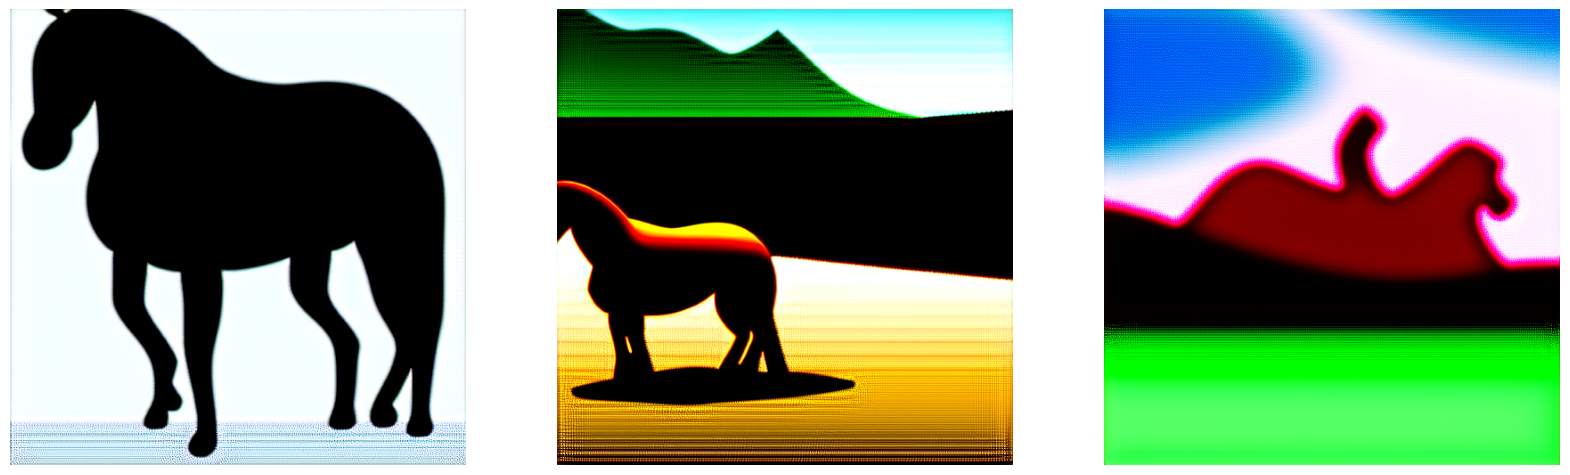

In [9]:
images = model.text_to_image("photograph of an astronaut riding a horse", batch_size=3)
# TF 2.16.1-gpu 에서는 동작. 2.17.0-gpu 에서는 에러.
# https://github.com/keras-team/keras-cv/issues/2467


def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")


plot_images(images)

꽤 놀랍네요!

하지만 이 모델이 할 수 있는 일은 그게 전부가 아닙니다. 좀 더 복잡한 프롬프트를 시도해 보겠습니다.

50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 320ms/step


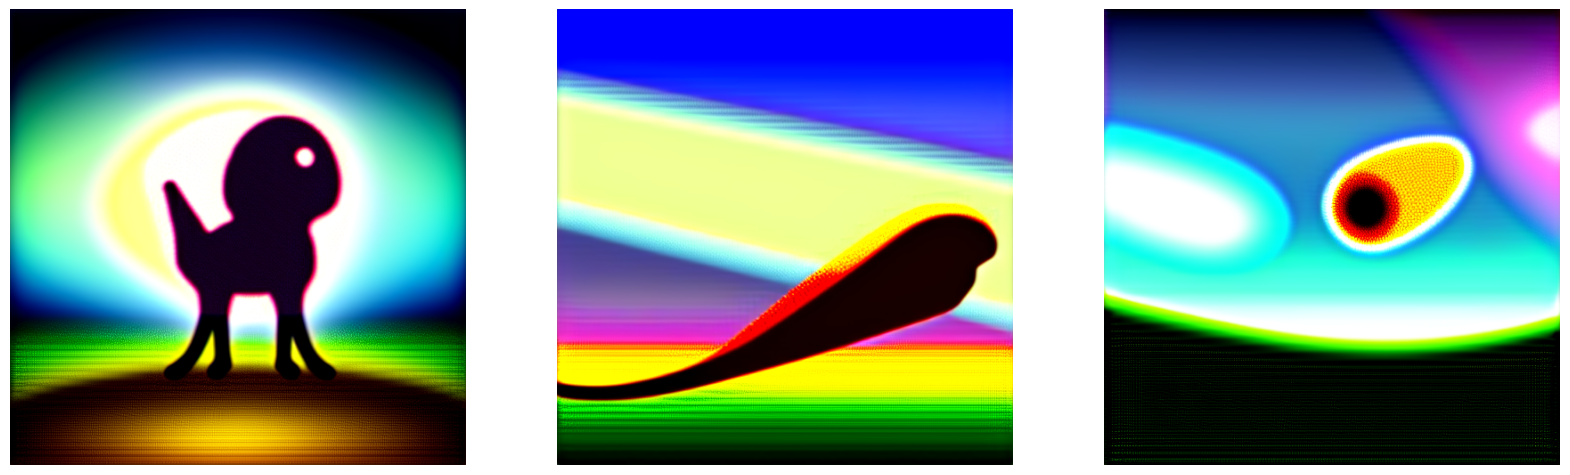

In [10]:
images = model.text_to_image(
    "cute magical flying dog, fantasy art, "
    "golden color, high quality, highly detailed, elegant, sharp focus, "
    "concept art, character concepts, digital painting, mystery, adventure",
    batch_size=3,
)
plot_images(images)

가능성은 문자 그대로 무한(또는 적어도 Stable Diffusion의 잠재 매니폴드의 경계까지 확장됩니다)합니다.

## 잠깐, 이게 어떻게 작동하는 걸까요?

이 시점에서 예상할 수 있는 것과 달리,
Stable Diffusion은 실제로 마법으로 실행되지 않습니다.
일종의 "잠재적 확산 모델"입니다.
그것이 무슨 뜻인지 살펴보겠습니다.

_super-resolution_ 이라는 개념에 익숙할 수 있습니다.
딥러닝 모델을 트레이닝하여, 입력 이미지의 _노이즈 제거(denoise)_ 를 수행하고,
이를 통해 고해상도 버전으로 변환할 수 있습니다.
딥러닝 모델은 노이즈가 많고 해상도가 낮은 입력에서, 누락된 정보를 마법처럼 복구하여 이를 수행하지 않습니다.
대신 모델은 트레이닝 데이터 분포를 사용하여 입력이 주어졌을 때. 가장 가능성이 높은 시각적 세부 사항을 환각합니다.
super-resolution에 대해 자세히 알아보려면, 다음 Keras.io 튜토리얼을 확인하세요.

- [효율적인 서브픽셀 CNN을 사용한 이미지 super-resolution](https://codecompose7.github.io/keras-doc-kr.github.io/examples/vision/super_resolution_sub_pixel/)
- [단일 이미지 super-resolution를 위한 향상된 딥 Residual 네트워크](https://codecompose7.github.io/keras-doc-kr.github.io/examples/vision/edsr/)

![Super-resolution](https://i.imgur.com/M0XdqOo.png)

이 아이디어를 한계까지 밀고 나가면,
그냥 순수한 노이즈에 그런 모델을 실행하면 어떨까 하고 생각하게 될 수 있습니다.
그러면, 모델은 "노이즈를 제거하고" 완전히 새로운 이미지를 환각하기 시작할 것입니다.
이 과정을 여러 번 반복하면, 작은 노이즈 패치를 점점 더 선명하고 고해상도의 인공적인 그림으로 바꿀 수 있습니다.

이것은 2020년 [잠재 확산(Latent Diffusion) 모델을 사용한 고해상도 이미지 합성](https://arxiv.org/abs/2112.10752)에서 제안된, 잠재 확산의 핵심 아이디어입니다.
확산을 심층적으로 이해하려면,
Keras.io 튜토리얼 [Diffusion 암묵적 모델 노이즈 제거](https://codecompose7.github.io/keras-doc-kr.github.io/examples/generative/ddim/)를 확인할 수 있습니다.

![Denoising diffusion](https://i.imgur.com/FSCKtZq.gif)

이제, 잠재 확산에서 텍스트-이미지 시스템으로 전환하려면, 여전히 하나의 핵심 기능을 추가해야 합니다.
프롬프트 키워드를 통해 생성된 시각적 콘텐츠를 제어하는 ​​기능입니다.
이는 "컨디셔닝(conditioning)"을 통해 수행됩니다.
이는 노이즈 패치에 텍스트 조각을 나타내는 벡터를 연결(concatenating)한 다음,
{image: caption} 쌍의 데이터 세트에 대해 모델을 트레이닝하는, 고전적인 딥러닝 기술입니다.

이를 통해, Stable Diffusion 아키텍처가 탄생했습니다. Stable Diffusion은 세 부분으로 구성됩니다.

- 텍스트 인코더
  - 프롬프트를 잠재 벡터로 변환하는 텍스트 인코더.
- 확산 모델
  - 64x64 잠재 이미지 패치를 반복적으로 "노이즈 제거"하는 확산 모델.
- 디코더
  - 최종 64x64 잠재 패치를 고해상도 512x512 이미지로 변환하는 디코더.

먼저, 텍스트 프롬프트는 텍스트 인코더에 의해 잠재 벡터 공간에 프로젝션됩니다.
텍스트 인코더는 단순히 사전 트레이닝된, 동결된 언어 모델입니다.
그런 다음, 해당 프롬프트 벡터는 무작위로 생성된 노이즈 패치에 연결(concatenated)되고,
이는 일련의 "단계"에 걸쳐 확산 모델에 의해 반복적으로 "노이즈 제거"됩니다.
(단계를 많이 실행할수록 이미지가 더 선명하고 좋아집니다. 기본값은 50 단계입니다)

마지막으로, 64x64 잠재 이미지는 디코더를 통해 전송되어, 고해상도로 적절하게 렌더링됩니다.

![The Stable Diffusion architecture](https://i.imgur.com/2uC8rYJ.png)

전반적으로 매우 간단한 시스템입니다.
Keras 구현은 총 500줄 미만의 코드를 나타내는 4개의 파일에 들어맞습니다.

- [text_encoder.py](https://github.com/keras-team/keras-cv/blob/master/keras_cv/models/stable_diffusion/text_encoder.py): 87 LOC
- [diffusion_model.py](https://github.com/keras-team/keras-cv/blob/master/keras_cv/models/stable_diffusion/diffusion_model.py): 181 LOC
- [decoder.py](https://github.com/keras-team/keras-cv/blob/master/keras_cv/models/stable_diffusion/decoder.py): 86 LOC
- [stable_diffusion.py](https://github.com/keras-team/keras-cv/blob/master/keras_cv/models/stable_diffusion/stable_diffusion.py): 106 LOC

하지만 이 비교적 간단한 시스템은 수십억 개의 사진과 캡션으로 트레이닝하면 마법처럼 보이기 시작합니다.
파인만이 우주에 대해 말했듯이: _"복잡하지 않아, 그저 양이 많을 뿐이야!"_

## KerasCV의 장점

여러 가지 Stable Diffusion 구현이 공개적으로 제공되고 있는데,
왜 `keras_cv.models.StableDiffusion`을 사용해야 할까요?

사용하기 쉬운 API 외에도, KerasCV의 Stable Diffusion 모델은 다음과 같은 강력한 장점을 제공합니다.

- 그래프 모드 실행
- `jit_compile=True`를 통한 XLA 컴파일
- 혼합 정밀도 계산 지원

이러한 기능을 결합하면, KerasCV Stable Diffusion 모델은 naive 구현보다 훨씬 빠르게 실행됩니다.
이 섹션에서는 이러한 모든 기능을 활성화하는 방법과,
이를 사용하여 얻은 성능 향상을 보여줍니다.

비교를 위해, Stable Diffusion의 [HuggingFace 디퓨저](https://github.com/huggingface/diffusers) 구현의 런타임을 KerasCV 구현과 비교하는 벤치마크를 실행했습니다.
두 구현 모두 각 이미지에 대해 50단계의 스텝 카운트로 3개의 이미지를 생성하도록 했습니다.
이 벤치마크에서는, Tesla T4 GPU를 사용했습니다.

[모든 벤치마크는 GitHub에서 오픈 소스이며, Colab에서 다시 실행하여 결과를 재현할 수 있습니다](https://github.com/LukeWood/stable-diffusion-performance-benchmarks).
벤치마크의 결과는 아래 표에 표시됩니다.


| GPU        | 모델                  | 실행 시간   |
|------------|------------------------|-----------|
| Tesla T4   | KerasCV (Warm Start)   | **28.97s**|
| Tesla T4   | diffusers (Warm Start) | 41.33s    |
| Tesla V100 | KerasCV (Warm Start)   | **12.45** |
| Tesla V100 | diffusers (Warm Start) | 12.72     |

Tesla T4에서 실행 시간이 30% 향상되었습니다!
V100에서는 개선 폭이 훨씬 낮지만,
일반적으로 벤치마크 결과는 모든 NVIDIA GPU에 걸쳐 KerasCV를 일관되게 선호할 것으로 예상합니다.

완전성을 위해, 콜드 스타트와 웜 스타트 생성 시간을 모두 보고합니다.
콜드 스타트 ​​실행 시간에는 모델 생성 및 컴파일의 일회성 비용이 포함되므로,
프로덕션 환경(동일한 모델 인스턴스를 여러 번 재사용하는 환경)에서는 무시할 수 있습니다.
그럼에도 불구하고, 콜드 스타트의 ​​숫자는 다음과 같습니다.

| GPU        | 모델                  | 실행 시간 |
|------------|------------------------|---------|
| Tesla T4   | KerasCV (Cold Start)   | 83.47s  |
| Tesla T4   | diffusers (Cold Start) | 46.27s  |
| Tesla V100 | KerasCV (Cold Start)   | 76.43   |
| Tesla V100 | diffusers (Cold Start) | 13.90   |

이 가이드를 실행한 런타임 결과는 다를 수 있지만,
테스트에서 KerasCV의 Stable Diffusion 구현은 PyTorch 대응 제품보다 상당히 빠릅니다.
이는 주로 XLA 컴파일 때문일 수 있습니다.

**참고: 각 최적화의 성능 이점은 하드웨어 설정에 따라 상당히 다를 수 있습니다.**

시작하려면, 먼저 최적화되지 않은 모델을 벤치마킹해 보겠습니다.

50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 320ms/step
Standard model: 16.28 seconds


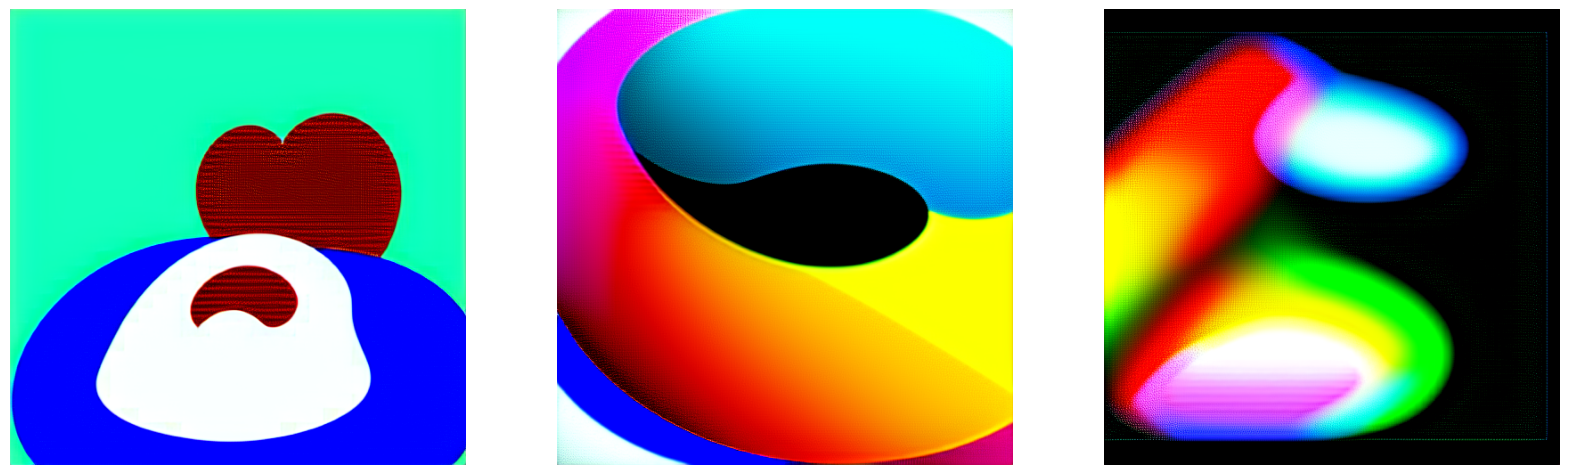

In [11]:
benchmark_result = []
start = time.time()
images = model.text_to_image(
    "A cute otter in a rainbow whirlpool holding shells, watercolor",
    batch_size=3,
)
end = time.time()
benchmark_result.append(["Standard", end - start])
plot_images(images)

print(f"Standard model: {(end - start):.2f} seconds")
keras.backend.clear_session()  # 메모리를 보존하기 위해, 세션을 클리어합니다.

### 혼합 정밀도 (Mixed precision)

"혼합 정밀도"는 `float32` 형식으로 가중치를 저장하는 동안,
`float16` 정밀도를 사용하여 계산을 수행하는 것으로 구성됩니다.
이는 `float16` 연산이 최신 NVIDIA GPU에서 `float32` 대응 연산보다,
훨씬 빠른 커널에 의해 지원된다는 사실을 이용하기 위해 수행됩니다.

Keras에서 혼합 정밀도 계산을 활성화하는 것(따라서 [`keras_cv.models.StableDiffusion`](https://codecompose7.github.io/keras-doc-kr.github.io/api/keras_cv/models/tasks/stable_diffusion#stablediffusion-class)은,
다음을 호출하는 것만큼 간단합니다.

In [12]:
keras.mixed_precision.set_global_policy("mixed_float16")

그게 전부입니다. 상자에서 꺼내자마자, 바로 작동합니다.

In [13]:
# model = keras_cv.models.StableDiffusion(jit_compile=False)
model = StableDiffusion(jit_compile=False)

print("Compute dtype:", model.diffusion_model.compute_dtype)
print(
    "Variable dtype:",
    model.diffusion_model.variable_dtype,
)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE
Compute dtype: float16
Variable dtype: float32


위에서 구성한 모델은, 이제 혼합 정밀도 계산을 사용합니다.
즉, 계산을 위해 `float16` 연산의 속도를 활용하는 동시에,
`float32` 정밀도로 변수를 저장합니다.

50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 160ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step
Mixed precision model: 8.20 seconds


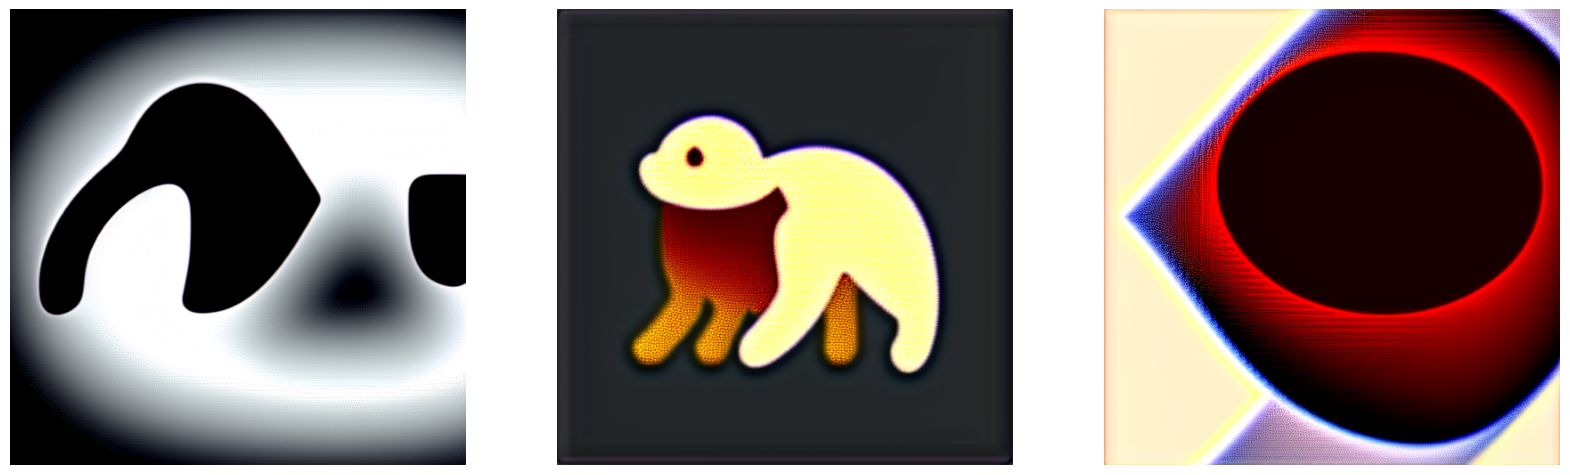

In [14]:
# 벤치마킹을 하기 전에, 그래프 추적을 실행하기 위해 모델을 워밍업합니다.
model.text_to_image("warming up the model", batch_size=3)

start = time.time()
images = model.text_to_image(
    "a cute magical flying dog, fantasy art, "
    "golden color, high quality, highly detailed, elegant, sharp focus, "
    "concept art, character concepts, digital painting, mystery, adventure",
    batch_size=3,
)
end = time.time()
benchmark_result.append(["Mixed Precision", end - start])
plot_images(images)

print(f"Mixed precision model: {(end - start):.2f} seconds")
keras.backend.clear_session()

### XLA 컴파일

TensorFlow와 JAX에는 [XLA: Accelerated Linear Algebra](https://www.tensorflow.org/xla) 컴파일러가 기본 제공됩니다.
[`keras_cv.models.StableDiffusion`](https://codecompose7.github.io/keras-doc-kr.github.io/api/keras_cv/models/tasks/stable_diffusion#stablediffusion-class)는 기본적으로 `jit_compile` 인수를 지원합니다.
이 인수를 `True`로 설정하면, XLA 컴파일이 활성화되어 속도가 상당히 향상됩니다.

아래에서 이것을 사용해 보겠습니다.

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 319ms/step


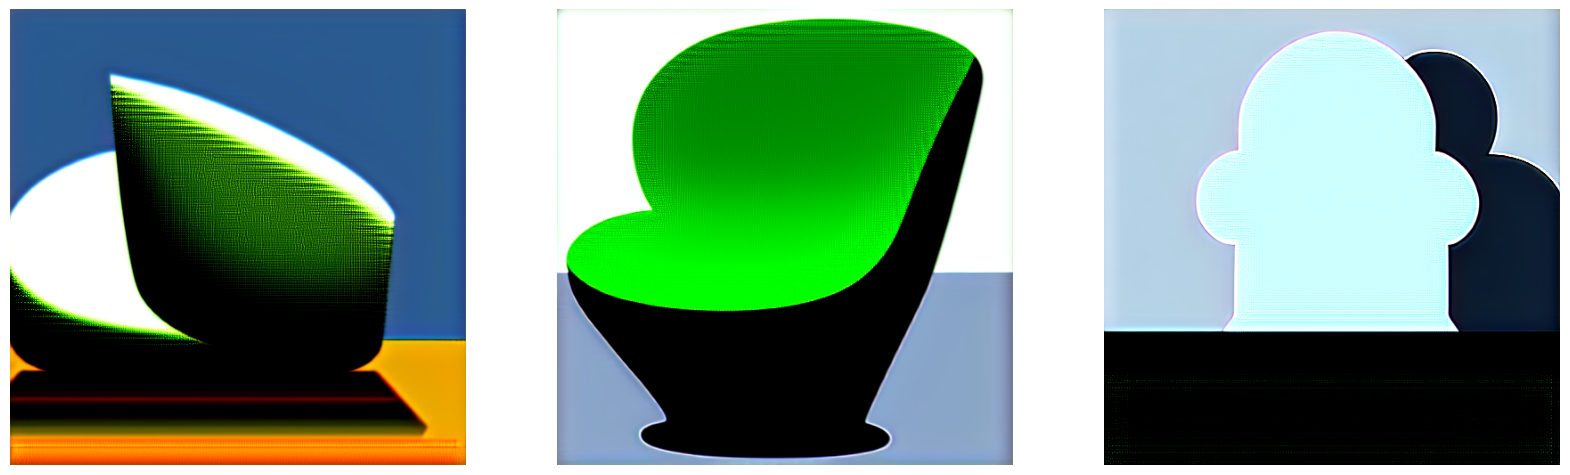

In [15]:
# 벤치마킹 목적으로 기본값으로 되돌립니다.
keras.mixed_precision.set_global_policy("float32")

# model = keras_cv.models.StableDiffusion(jit_compile=True)
model = StableDiffusion(jit_compile=True)
# 모델을 벤치마킹하기 전에,
# 추론을 한 번 실행하여,
# TensorFlow 그래프가 이미 추적되었는지 확인합니다.
images = model.text_to_image("An avocado armchair", batch_size=3)
plot_images(images)

XLA 모델을 벤치마킹해 보겠습니다.

50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 320ms/step
With XLA: 16.28 seconds


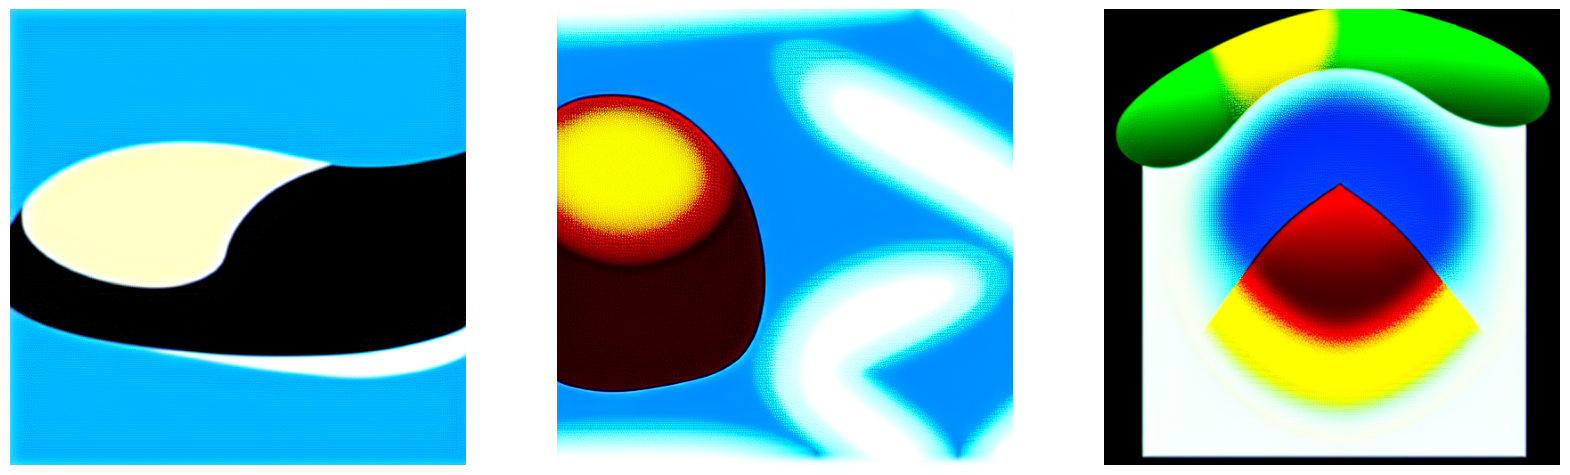

In [16]:
start = time.time()
images = model.text_to_image(
    "A cute otter in a rainbow whirlpool holding shells, watercolor",
    batch_size=3,
)
end = time.time()
benchmark_result.append(["XLA", end - start])
plot_images(images)

print(f"With XLA: {(end - start):.2f} seconds")
keras.backend.clear_session()

A100 GPU에서는, 약 2배의 속도 향상을 얻습니다. 환상적이죠!

## 모두 합치기

그렇다면, (2022년 9월 기준으로) 세계에서 가장 성능이 뛰어난,
stable diffusion 추론 파이프라인을 어떻게 조립합니까?

다음 두 줄의 코드로:

In [17]:
keras.mixed_precision.set_global_policy("mixed_float16")
# model = keras_cv.models.StableDiffusion(jit_compile=True)
model = StableDiffusion(jit_compile=True)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


그리고 그것을 사용하려면...

50/50 ━━━━━━━━━━━━━━━━━━━━ 45s 160ms/step


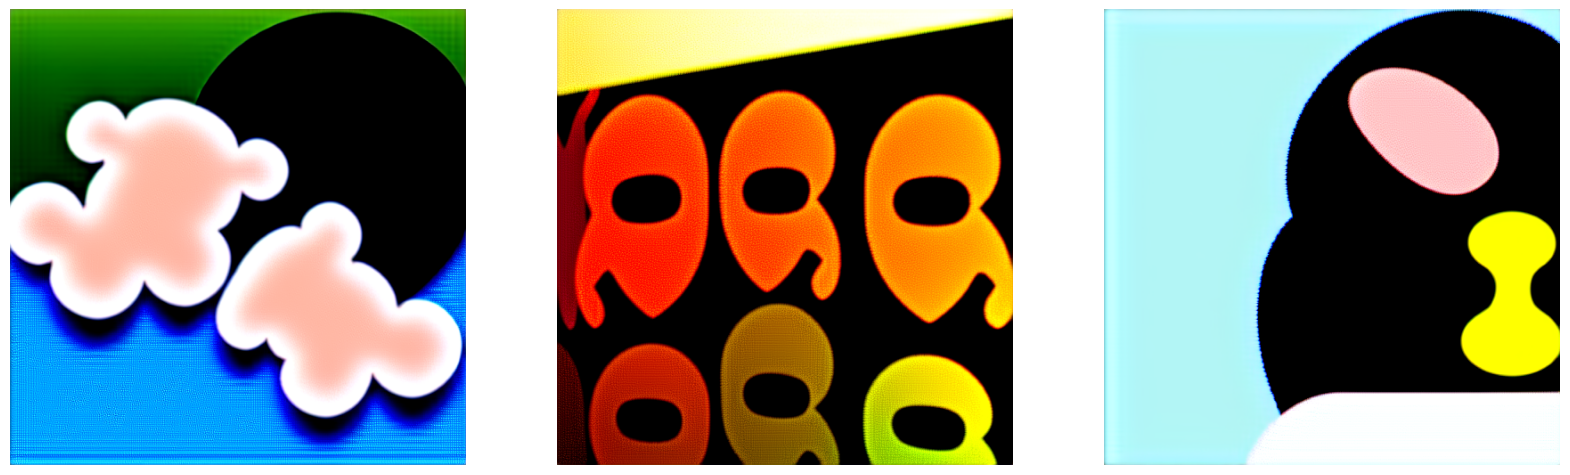

In [18]:
# 모델을 워밍업하는 것을 잊지 마세요.
images = model.text_to_image(
    "Teddy bears conducting machine learning research",
    batch_size=3,
)
plot_images(images)

정확히 얼마나 빠른가요? 알아보죠!

50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step
XLA + mixed precision: 8.22 seconds


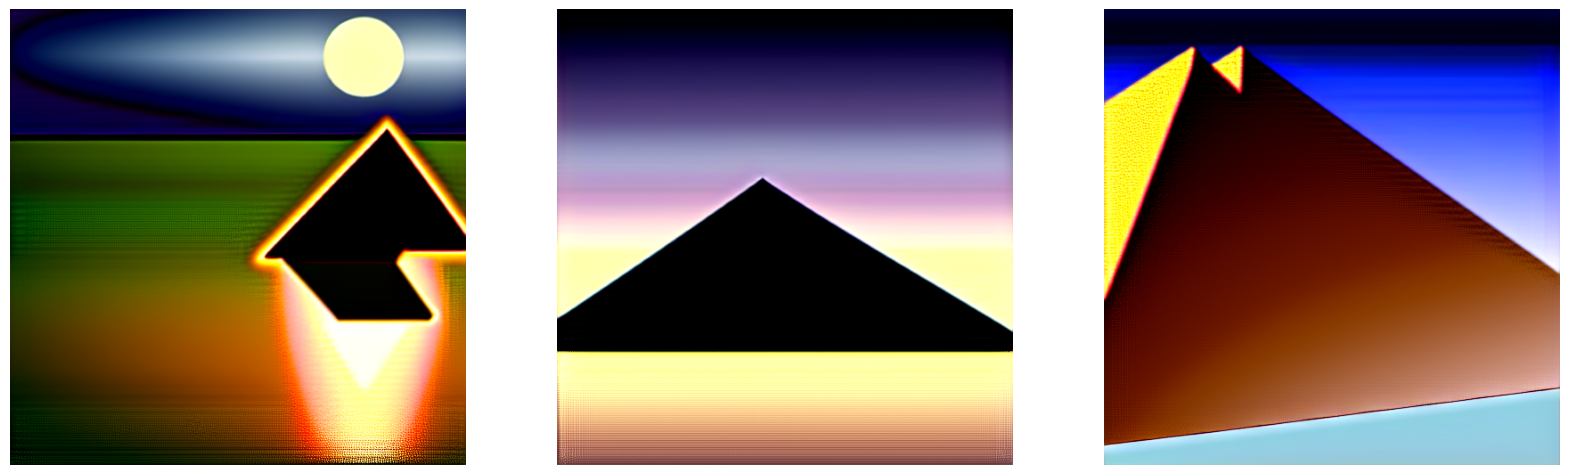

In [19]:
start = time.time()
images = model.text_to_image(
    "A mysterious dark stranger visits the great pyramids of egypt, "
    "high quality, highly detailed, elegant, sharp focus, "
    "concept art, character concepts, digital painting",
    batch_size=3,
)
end = time.time()
benchmark_result.append(["XLA + Mixed Precision", end - start])
plot_images(images)

print(f"XLA + mixed precision: {(end - start):.2f} seconds")

결과를 확인해 보겠습니다.

In [20]:
print("{:<22} {:<22}".format("Model", "Runtime"))
for result in benchmark_result:
    name, runtime = result
    print("{:<22} {:<22}".format(name, runtime))

Model                  Runtime               
Standard               16.2755925655365      
Mixed Precision        8.19576644897461      
XLA                    16.27723503112793     
XLA + Mixed Precision  8.219487428665161     


완전히 최적화된 모델은,
A100 GPU에서 텍스트 프롬프트로부터 세 개의 새로운 이미지를 생성하는 데 불과 4초가 걸렸습니다.

## 결론

KerasCV는 Stable Diffusion의 최첨단 구현을 제공하며,
XLA와 혼합 정밀도를 사용하여,
(2022년 9월 현재) 사용 가능한 가장 빠른 Stable Diffusion 파이프라인을 제공합니다.

일반적으로, keras.io 튜토리얼의 마지막에 학습을 계속할 수 있는 몇 가지 향후 지침을 제공합니다.
이번에는 한 가지 아이디어를 제공합니다.

**모델에서 직접 프롬프트를 실행해 보세요! 정말 최고예요!**

NVIDIA GPU나 M1 MacBookPro가 있는 경우,
머신에서 로컬로 모델을 실행할 수도 있습니다.
(M1 MacBookPro에서 실행할 때는 아직 Apple의 Metal 런타임에서 잘 지원되지 않으므로,
혼합 정밀도를 활성화해서는 안 됩니다.)
